## Modelling RV data of 51 Peg b
### As part of the exoplanet course "[De exoplanetas y otros demonios](https://www.dropbox.com/s/den1m7u7029a9bi/exoplanetas_2019.odp?dl=0)", at Bucaramanga, Santander, Colombia
##### Oscar Barragán, Dec 2019

In [1]:
#Import main libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Let us write a function to compute RV for a circular orbit
#input parameters are time t (vector with N elements)
#and the model parameters
#in this case
#params[0] -> vz -> Systemic velocity of the star
#params[1] -> K  -> Doppler semi-amplitude
#params[2] -> P  -> Orbital period
#params[3] -> T0 -> time of minimum conjunction 
#This function returns a vector (N elements) of RVs at the times t
def calcula_RV(t,params):
    vz = params[0]
    K  = params[1]
    P  = params[2]
    t0 = params[3]
    vr = vz - K * np.sin(2*np.pi*(t-t0)/P)
    return vr

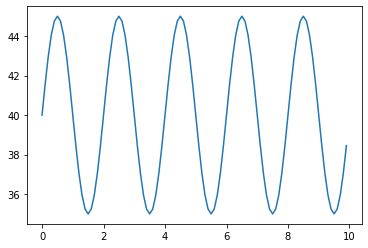

In [3]:
#Let us check if the function works by plotting an RV curve

#let us create a time vector between 0 and 10 days with a point each 0.1 days
t = np.arange(0,10,0.1)
#Let us give some values for the 4 parameters that define the RV of a circular orbit
vz = 40 #km/s
K = 5   #km/s
P = 2   #days
t0 = 13 #days

#Let us call the function to estimate the RV for a circular orbit
vr = calcula_RV(t,[vz,K,P,t0])
#Now we have a vector vr that contains the RV of our fictional star at the times t
plt.plot(t,vr)

#NOTE: If you want to know how the curve changes with different values
#I encourage you to modify the parameters and see how the plot changes
#this will give you a better idea of how the equation works ;-)

## Time to work with real data!
### We will work with the RV data of 51 Peg b, the first exoplanet discovered around a Sun-like star.
### You can find the original paper [here](https://www.nature.com/articles/378355a0)

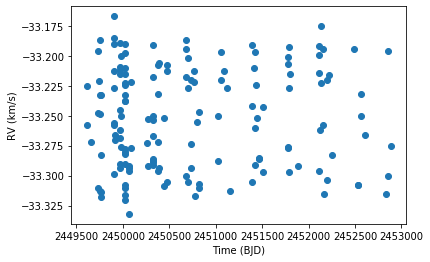

In [4]:
#if you are using Google collab, uncomment the next two lines
#from google.colab import files
#uploaded=files.upload()

#First we need to read the file with the real RV data
#The file is in the same repository than this jupyter notebook
#Note the format of the file
#3 columns, first column is time, second column is RV (km/s), and 
#third one is the error on RV (also in km/s)
#To perform the fit, we need the three quantities

#Let us load the file
#I use numpy because it requires the minimum of packages, but you can
#chage it to your favourite tool to read files
td, rvd, ed = np.loadtxt('51peg.dat',unpack=True,usecols=[0,1,2])

#Now we have the the Nobel-prize-worth observations!

#Let us plot the data to see how they look like
plt.plot(td,rvd,'o')
#Time is given in some units called Barycentric Julian Date (BJD)
plt.xlabel('Time (BJD)')
#Radial velocity is given in km/s
plt.ylabel('RV (km/s)')
plt.show()

## What can we see in the previous plot?

### We see that the y-axis, the one corresponding to the RV, is around -33.25 km/s. This is caused because the star has a velocitiy along our line of sight, as you may guess, since the velocity is negative, this means that this star (51 Peg) is approaching to us! But, we see that there is some disperssion on the RV around  -33.25 km/s, this is caused because the planet is pulling the star, _id est_, the RV wobbling that whisper us the presence of 51 Peg b!

### Time to model that data to see what we can learn of the planet ;-)

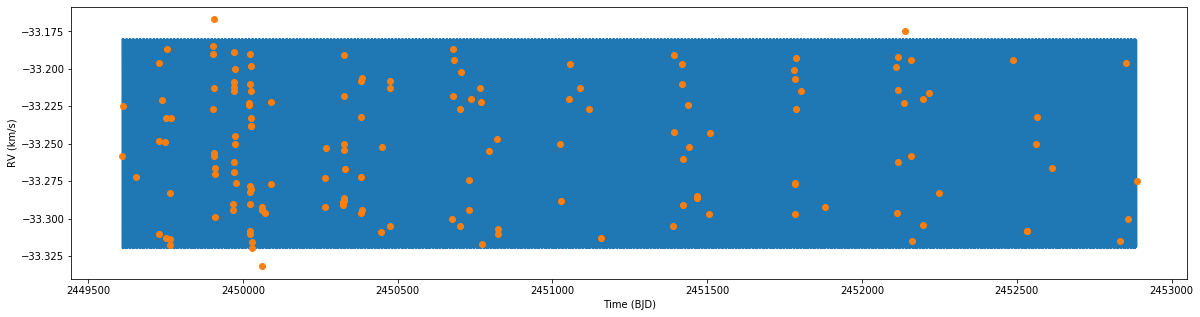

In [5]:
#Let us create a first model just to compare with the data

#The model time-stamps are created inside the range of time of the data
t = np.arange(min(td),max(td),0.11)

#Let us give some values to our 4 parameters
#Note: We have a good idea of the systemic velocity (velocity respect to the line of sight)
#of the star from the previous plot
vz = -33.25
K  = 0.070
P  = 2.
t0 = 13.

#Now let us compute our model using our 4 parameter estimates
vr = calcula_RV(t,[vz,K,P,t0])

#Now let us plot the model and the data

#this line plots the model
plt.figure(figsize=(20,5))
plt.plot(t,vr)
#this line plots the data
plt.plot(td,rvd,'o')
#Time is given in some units called Barycentric Julian Date (BJD)
plt.xlabel('Time (BJD)')
#Radial velocity is given in km/s
plt.ylabel('RV (km/s)')
plt.show()

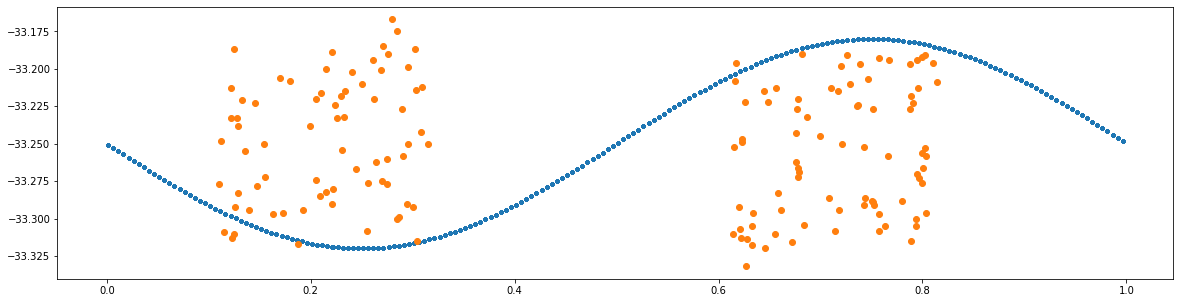

In [6]:
#We can see that it is hard to see in the previous plot if the model is good
#this is caused because the time window is quite big (several years of observations)
#A good way to show RV plots is using the so called phase-folded plot
#Instead of putting time in the x-axis, one puts the fraction (phase) of the orbit
#at which the RV is computed. This transforms the x-axis in
#the pase that goes from 0 to 1. The pase is computed as
# phase = ((time - time_0)%P)/P, where % computes the residual

#Now we can compute the phase for the model and the data as
phase_model = (t-t0)%P/P
phase_data  = (td-t0)%P/P

#Now let us create the plot again 
plt.figure(figsize=(20,5))
#this line plots the model
plt.plot(phase_model,vr,'.')
#this line plots the data
plt.plot(phase_data,rvd,'o')
plt.show()

#And the plot looks like this

### Hum, the model does not explain really well the data
### This is because the model parameters that we use in the previous cells were selected by us without doing any optimisation. 
### We could keep changing the parameters by hand until we get some good model that looks more like our data. But let's be honest, that is boring and time consuming. This is where we have to use the magic of optimisation functions in python.

### In this example we will learn how to estimate the model parameters using something called $\chi^2$ (it is pronounced as ki-square and I will write it as chi^2) minimisation.

### I will not give details on the theory behind the $\chi^2$, a more detailed discussion can be found [here](https://arxiv.org/abs/1012.3754). But briefly, $\chi^2$ is a quantity than compares how _close_ is a model with the data, a small $\chi^2$ indicates that the model explains well the data, for this reason, if we want to find the best model that explains our data, we need to find the smallest one, we need to *minimise the $\chi^2$*.

### So, the definition of the $\chi^2$ is 

### $\chi^2 = \sum_{i=1}^N \frac{ (D_i - M_i)^2 } {\sigma_i^2}$

### Where $D_i$ is the data point taken at the time $t_i$, $M_i$ is the model at the time $t_i$ and $\sigma_i$ is the error bar of $D_i$. 

### More details on the meaning of the $\chi^2$ can be found online. By now, let us write a function that computes the $\chi^2$ for a RV model assuming the planet follows a circular orbit. 

### By looking to the $\chi^2$ equation, we need to give the data and some parameters to create the model. In this case our data are the time of the observations, the RV an their error bars. And our model depends on 4 parameters (vz, K, P and t0).

In [7]:
#let us create a function to compute the chi^2 for our model
#input values are
#param -> a vector containing the model parameters, in this case
#         the 4 parameters required to compute the RV model.
#t     -> a vector with all the time of the observations
#y     -> RV measurements
#e     -> the errors associated to the RV measurements 
#This function returns a scalar corresponding to the $\chi^2$
def chi2(param,t,y,e):
    #First we need to compute the values that the model has at 
    #the same time that the observations
    #We can do it easily with our calcula_RV function and the time t
    vr = calcula_RV(t,param)
    #Now let us compute the chi^2 following the equation 
    #previously described and the magic of python 
    chi2 = np.sum(1./2. * ( (vr - y) / e)**2)
    return chi2

#let us test our chi2 function
chi = chi2([vz,K,P,t0],td,rvd,ed)
print(chi)

9154.115733319886


## Now it is time to minimise the $\chi^2$ to find the best model that describes our data, in this way, we can determine the model parameters. 

In [8]:
#Let us minimise the chi2 function using a spicific python routine designed for that
#it is called fmin and details can be find here -> 
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html

#first import fmin from a widely used python library called scipy
from scipy.optimize import fmin

#Some important thing about this kind of minimisation is that we need to 
#give some guesses of where the minimisation routine has to start to search
#for the solution.
#We will not discuss that in this tutorial but usually a good
#way to estimate the best guess of parameters is via a Periodogram
#that search for periodic signals in time-series
#More details about this can be found here ->
#https://astropy.readthedocs.io/en/stable/timeseries/lombscargle.html
#We assume that we used a periodogram in our time-series and we have the guesses
vz = -33.250
K = 0.06
P = 4.2
t0 = min(td)

#Let us tell to python the fuction that we want to minimise
params_final = fmin(chi2,[vz,K,P,t0],args=(td,rvd,ed))

#Let us print the parameters that best explain our data?
print("\n Minimisation completed!")
print("I found:")
print("VZ = ",params_final[0]," km/s")
print("K  = ",params_final[1]," km/s")
print("P  = ",params_final[2]," days")
print("T0 = ",params_final[3]," BJD")

Optimization terminated successfully.
         Current function value: 238.019395
         Iterations: 182
         Function evaluations: 387

 Minimisation completed!
I found:
VZ =  -33.25610805215914  km/s
K  =  0.060315265346629704  km/s
P  =  4.2307829278247695  days
T0 =  2527382.923067239  BJD


### Are these parameters similar to the ones presented in the original 51 Peg b paper?

### A good way to check if these parameters explain the data, is to plot the model together with the data. Let us create a phase folded plot as we did previously.

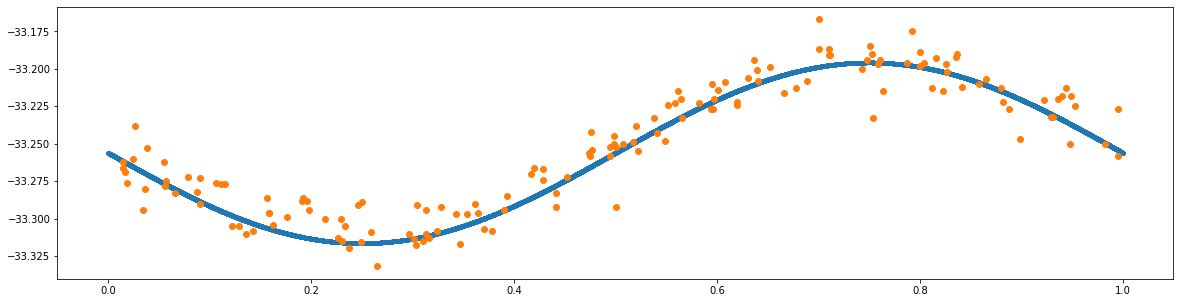

In [9]:
#Let us create a model using the time window from the observations
t = np.arange(min(td),max(td),0.1)

#Now let us compute the RV model based on the parameters coming from
#the minimisation routine
vr = calcula_RV(t,params_final)

vz = params_final[0]
K  = params_final[1]
P  = params_final[2]
t0 = params_final[3]

#let us transform the times into phase
phase_model = (t-t0)%P/P
phase_data  = (td-t0)%P/P

#The time of the truth, let us create the plot!
plt.figure(figsize=(20,5))
#this line plots the model
plt.plot(phase_model,vr,'.')
#this line plots the data
plt.plot(phase_data,rvd,'o')
plt.show()

## Here it is! Our model and our data look really good together.

## As the final step, we will estimate the minimum mass of the planet that is dancing with 51 Peg b

## If we assume that the mass of the planet is much smaller than the mass of the star, the equation to estimate the minimum mass of the planet goes as

## $m_{\rm planet} \sin i = K \left( \frac{2 \pi G}{P} \right)^{-1/3} m_{\rm star}^{2/3} (1 - e^2)^{1/2}$  

## Since we are dealing with circular orbits, the equation reduces to 

## $m_{\rm planet} \sin i = K \left( \frac{2 \pi G}{P} \right)^{-1/3} m_{\rm star}^{2/3}$  

## If you look carefully, we already estimated $K$ and $P$ from our optimisation. $\pi$ and $G$ are constants and the stellar mass can be determined from independent methods, so we are ready to get the planet minimum mass.

In [10]:
#Let us estimate the planet minimum mass

#Let us define some constants that we will need
#Gravitational constant in SI units
G_SI = 6.67408e-11 #m^3 kg^{-1} s^{-2}
#1 Solar mass in SI units
M_SUN_SI = 1.989e+30 #kg
#1 Jupiter mass in SI units
M_JUP_SI = 1.899e+27 #kg

#Let's be careful, our K was estimated in km/s, we have to transform it to m/s
K_ms = K*1.e3

#And our period was estimated in days, let us transform it to secs
P_s  = P*24.*3600. #a day has 24 hours and an our nas 3600s

#And the mass of the star in kilograms
#The mass of 51 Peg is 1.11 Solar masses, so the mass of 51 Peg in kg is
M_star_kg = 1.11*M_SUN_SI

#And the planet minimum mass is then
M_planet_kg =  K_ms * (2*np.pi*G_SI/P_s)**(-1./3.)*M_star_kg**(2./3.)

#Now we have the planet minimum mass in kg, but let us transform it
#to Jupiter masses

M_planet_jup = M_planet_kg/M_JUP_SI

#And the minimum mass of 51 Peg b that we calculated is
print("51 Peg b minimum mass is: ",M_planet_jup," Jupiter masses")

51 Peg b minimum mass is:  0.5144326473916259  Jupiter masses


## And the value is in well agreement with the 0.47 Jupiter masses value reported in the original 51 Peg b paper. 